In [1]:
import os
import pandas as pd
import re
from collections import defaultdict
from datasets import Dataset



from parser import clean, get_resume_sections

df = pd.read_csv("UpdatedResumeDataSet.csv", encoding="utf-8")
df.drop_duplicates(subset=["Resume"], keep="first", inplace=True)
df.reset_index(inplace=True, drop=True)
df["Clean"] = df["Resume"].apply(clean)

/Users/maximkim/MDST/resume-screener/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


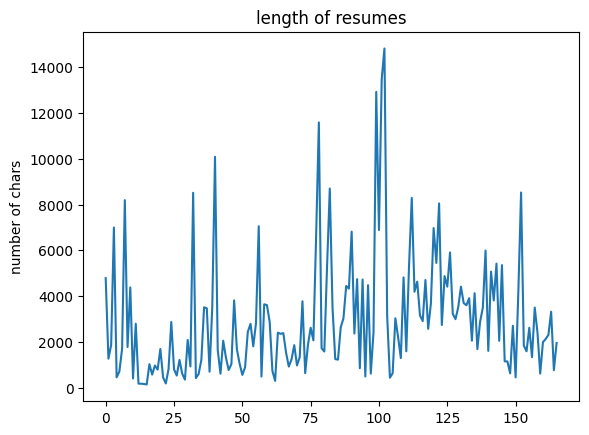

In [2]:
import matplotlib.pyplot as plt

lengths = []
for row in df["Clean"]:
    lengths.append(len(row))

plt.plot(lengths)
plt.title("length of resumes")
plt.ylabel("number of chars")
plt.show()



In [70]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import numpy as np

model_name = "thenlper/gte-base"
embedding_model = HuggingFaceEmbeddings(model_name=model_name)
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=300,
    chunk_overlap=50,
    length_function=len
)

To test this, reduce chunk_size and chunk_overlap from earlier

In [71]:
text = "hello there my guy you are such a guy dude guy yaya yaya"

def chunk_data(text):
    docs = splitter.create_documents(texts=[text])
    return [doc.page_content for doc in docs]

def embed_chunks(chunks):
    return embedding_model.embed_documents(chunks)

chunks = chunk_data(text)
print(chunks)
embedded = embed_chunks(chunks)
print(embedded)
    

['hello there my guy you are such a guy dude guy yaya yaya']
[[-0.0012242910452187061, -0.012970250099897385, 0.009754830971360207, 0.019019102677702904, 0.026360496878623962, 0.010024252347648144, 0.05536678060889244, 0.06483981758356094, -0.0386713482439518, -0.0584564134478569, -0.014085439965128899, 0.011918534524738789, -0.04137302190065384, 0.004030672367662191, -0.015703285112977028, 0.07356765866279602, 0.07172895222902298, 0.0019875038415193558, 0.02538573183119297, 0.005252043250948191, -0.004389501642435789, 0.0007695987587794662, 0.02632075361907482, 0.0071949721314013, 0.014643811620771885, -0.013764429837465286, -0.033641934394836426, 0.04402585327625275, -0.07076282799243927, -0.022726763039827347, 0.03516467288136482, 0.0017697378061711788, 0.012717221863567829, -0.039876971393823624, -0.04122529551386833, -0.020886102691292763, -0.010542168281972408, 0.006501937285065651, 0.005712850950658321, -0.01801019161939621, -0.022091932594776154, -0.013020866550505161, -0.02783

In [72]:
df = df[:5]
df["Chunks"] = df["Clean"].apply(chunk_data)
df["Embeddings"] = df["Chunks"].apply(embed_chunks)
df

,Category,Resume,Clean,Chunks,Embeddings
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills * Programming Languages: Python (pandas...,[Skills * Programming Languages: Python (panda...,"[[0.01287016086280346, -0.01536303386092186, 0..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details \r\nMay 2013 to May 2017 B.E...,[Education Details \r\nMay 2013 to May 2017 B....,"[[0.02041388303041458, -0.019160525873303413, ..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","Areas of Interest Deep Learning, Control Syste...","[Areas of Interest Deep Learning, Control Syst...","[[0.02442571334540844, 0.01927502639591694, -0..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Table...,[Skills R Python SAP HANA Tabl...,"[[0.007373979315161705, 0.012433757074177265, ..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","Education Details \r\n MCA YMCAUST, Faridab...","[Education Details \r\n MCA YMCAUST, Farida...","[[0.02551179751753807, -0.03329223394393921, 0..."


Embedding lengths are determined by model, so all will be the same

In [73]:
example = df["Embeddings"][0]
lengths = set([len(x) for x in example])
print(lengths)
EMBEDDING_LENGTH = list(lengths)[0]

{768}


Download postgres and run service

run 
```
CREATE EXTENSION vector;
```
Exactly once in the DB you're storing these tables

In [ ]:
from random import randint
import psycopg
from pgvector.psycopg import register_vector

def load_db(df):
    with psycopg.connect("user=postgres") as conn:
        register_vector(conn)
        with conn.cursor() as cur:
            table_name = "resume_docs"
            cur.execute(f"DROP TABLE IF EXISTS {table_name}")
            cur.execute(
                f"""
                CREATE TABLE {table_name}(
                    id serial PRIMARY KEY,
                    source_id integer,
                    chunk text,
                    embedding vector({EMBEDDING_LENGTH})
                )   
                """
            )

            for i, row in df.iterrows():
                embeds = row["Embeddings"]
                chunks = row["Chunks"]
                for i in range(len(embeds)):
                    cur.execute(
                        f"INSERT INTO {table_name} (source_id, chunk, embedding) VALUES (%s, %s, %s)", 
                        (i, chunks[i], embeds[i])
                    )

            for x in cur.execute(f"SELECT * FROM {table_name}"):
                print(x)

load_db(df)

(1, 0, 'Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, Na  ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language', '[0.012870161,-0.015363034,0.028852174,0.03532658,0.07265183,0.04754925,0.03748371,0.017688654,-0.023454394,-0.045223847,-0.023208324,0.04030157,-0.054492876,0.0011332729,0.0162372,0.043182675,0.049837425,0.008241821,0.026206616,-0.004012184,-0.025026552,-0.022597412,0.005308817,0.022079663,0.00945715,-0.014274825,0.0018239114,0.01120043,-0.08529038,0.010238669,0.055904116,0.019387417,-0.011633616,-0.01234935,-0.009370644,0.0031715755,0.0132489465,0.04293166,0.001094776,0.005202205,-0.03491688,-0.008748669,-0.0240114,0.048927464,-0.050928716,0.0040722615,-0.05669541,0.023788704,0.006078845,-0.013429698,-0.051151376,0.065864325,0.026526386,-0.02213246,-0.029151693,0.06469623,0.0126036

Create vector to compare

In [ ]:
query = "give me someone with data science experience"
res = embedding_model.embed_query(query)
print(res)
print(len(res))

[0.021484410390257835, -0.006088511552661657, -0.013936805538833141, 0.058163318783044815, 0.0775236263871193, 0.017765402793884277, 0.03626751899719238, 0.017186101526021957, 0.0027045251335948706, -0.046994078904390335, -0.013963911682367325, 0.020222913473844528, -0.05896403640508652, 0.005183475092053413, 0.00765581289306283, 0.05139719694852829, 0.0573180615901947, 0.0063589876517653465, 0.03686341270804405, 0.0032238413114100695, -0.02314537577331066, -0.0037826348561793566, -0.030986130237579346, 0.020878812298178673, 0.0037711283657699823, -0.043368276208639145, 0.01325488742440939, 0.00801559817045927, -0.058450162410736084, 0.011291686445474625, 0.033001575618982315, 0.0030448033940047026, -0.016781043261289597, -0.007642203476279974, -0.05863480269908905, 0.03029082715511322, -0.0022183575201779604, -0.0005456303479149938, 0.002466843230649829, -0.00564414681866765, -0.05923759937286377, -0.014369528740644455, -0.031111260876059532, 0.019080355763435364, -0.06330235302448273

In [ ]:
# def retrieve_k_closest(query, k):
#     with open()